In [81]:
import jsonlines
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import PercentFormatter
from plot_helper import statewide_seats
from party_lists.party_list import random_list, alt_random
import numpy as np
from gerrytools.plotting import boxplot
from collections import defaultdict
import geopandas as gpd
import os

Make histograms for:
- STV
- Plurarlity 
- IRV
- Party List

for SEN18 partisan elections for 8 by 5, 32 by 5 (STV, Party Lists) 40 by 1 and 160 by 1 (IRV, Plurality)

percent of the ensemble on the y-axis 

In [82]:
stv = []
for i in range(1, 6):
    stv.append(statewide_seats(f'../output/massachusetts-0-0-8-partisan-basic/neutral-{i}.jsonl'))

In [83]:
irv = []
for i in range(0, 5):
    irv.append(statewide_seats(f"../output/irv_results/40-plan-{i}.jsonl"))

In [84]:
plurality = []

plans = []
with jsonlines.open('output/plans/IRV/pl_ensembles-40.jsonl') as r:
    for line in r:
        plans.append(line)

for plan in plans:
    state_seats = 0
    for zone_share in plan["SEN18"]:
        if zone_share <= 0.5:
            state_seats += 1
    
    plurality.append(state_seats)

In [86]:
pl_plans = []
with jsonlines.open('party_lists/data/results/pl_ensembles-8.jsonl') as r:
    for line in r:
        pl_plans.append(line)

#Sort plans by from least to greatest republican vote share
elections = ["SEN18"]
sorted_plans = []
for plan in pl_plans:
    part = {election : None for election in elections}
    for election in elections:
        part[election] = sorted(plan[election], reverse=True)
    sorted_plans.append(part)

# generates list containing the party list results for reach election 
election_results = []
num_seats = 5
num_districts = 8

for election in elections:
    total_seats = {district : [] for district in range(num_districts)} 
    for plan in sorted_plans:
        results = alt_random(plan, num_seats)
        for district, d_results in results[election].items():
            cands, elected, party = d_results
            if party == 'Republican':
                total_seats[district].append(elected)
            elif party == 'Democrat':
                total_seats[district].append(num_seats-elected)
    
    election_results.append(total_seats)

# compute statewide seats gained 
pl_seats = []
num_plans = len(plans)

for results in election_results:
    state_seats = []
    for i in range(num_plans):
        seats = 0
        for dist in range(num_districts):
            seats += results[dist][i]
        state_seats.append(seats)
    pl_seats += state_seats

In [92]:
#Find republican seats for IRV
tot_seats = num_districts * num_seats
irv_tot = []
for plan in irv:
    for model, dem_seats in plan.items(): #get seats
        # if 'cambridge,' not in model:
        all_seats = np.full(len(dem_seats), tot_seats)
        rep_seats = all_seats -dem_seats
        irv_tot += list(rep_seats)

In [93]:
# Merge STV seats into one giant ass list
stv_tot = []
for plan in stv:
    for model, rep_seats in plan.items():
        # if 'cambridge' not in model:
        stv_tot += list(rep_seats)

In [89]:
ma = gpd.read_file('party_lists/data/MA_vtd20/MA_vtd20.shp')
ma_votes = ma[['SEN18D', 'SEN18R', 'GOV14D', 'GOV14R', 
            'GOV18D', 'GOV18R', 'SEN20GKOCO', 'SEN20GEMAR', 
            'PRES20GJBI', 'PRES20GDTR']].sum()

15


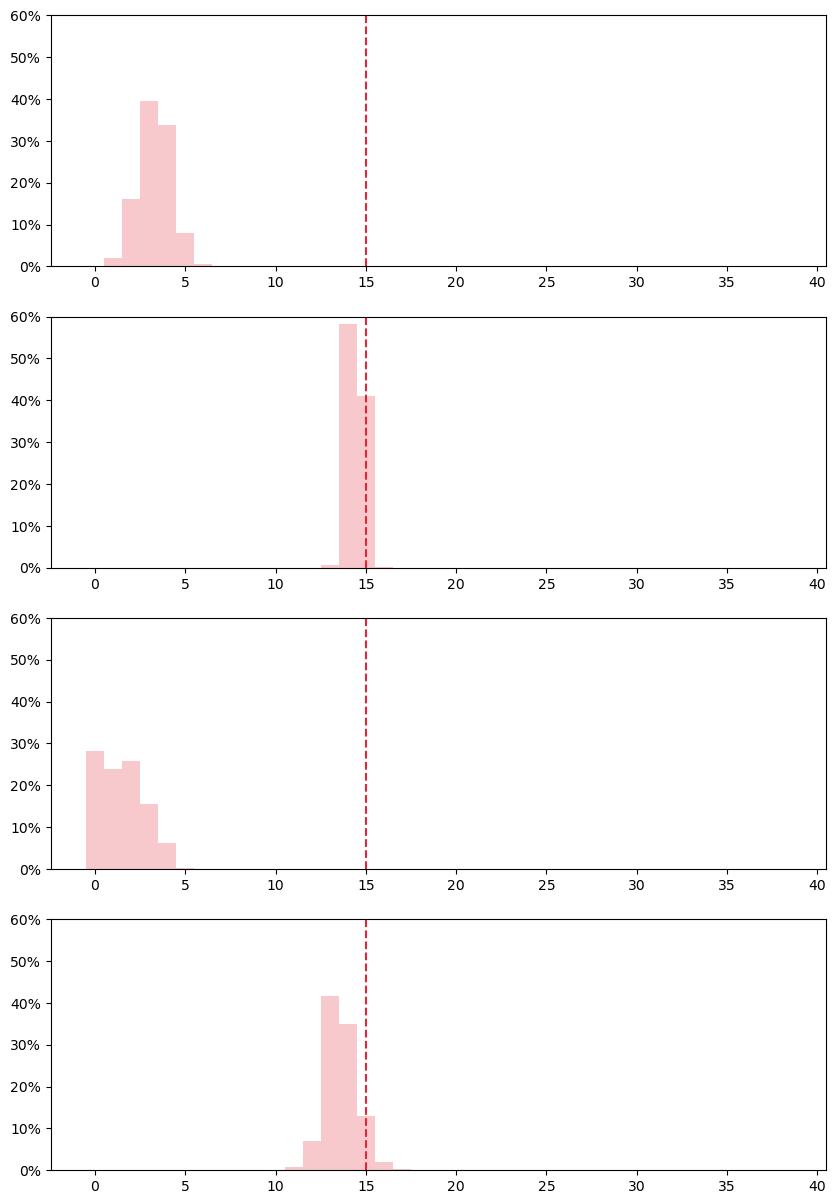

In [94]:
#create plot
fig, axes = plt.subplots(4, figsize=(10, 15))
axes[0].hist(plurality, bins=list(range(0,tot_seats)), color='#E32636', label='SEN18', alpha=0.25, align='left', weights=np.ones(len(plurality)) / len(plurality))
axes[0].yaxis.set_major_formatter(PercentFormatter(1))

axes[1].hist(pl_seats, bins=list(range(0,tot_seats)), color='#E32636', label='SEN18', alpha=0.25, align='left', weights=np.ones(len(pl_seats)) / len(pl_seats))
axes[1].yaxis.set_major_formatter(PercentFormatter(1))

axes[2].hist(irv_tot, bins=list(range(0,tot_seats)), color='#E32636', label='SEN18', alpha=0.25, align='left',  weights=np.ones(len(irv_tot)) / len(irv_tot))
axes[2].yaxis.set_major_formatter(PercentFormatter(1))

axes[3].hist(stv_tot, bins=list(range(0,tot_seats)), color='#E32636', label='SEN18', alpha=0.25, align='left', weights=np.ones(len(stv_tot)) / len(stv_tot))
axes[3].yaxis.set_major_formatter(PercentFormatter(1))

for ax in axes:
    ax.set_ylim(0, 0.60)
    ax.axvline(round(tot_seats*(ma_votes['SEN18R']/(ma_votes['SEN18D'] + ma_votes['SEN18R']))), color='#E32636', linestyle='dashed')

print(round(tot_seats*(ma_votes['SEN18R']/(ma_votes['SEN18D'] + ma_votes['SEN18R']))))